![](https://www.meme-arsenal.com/memes/493c60111ad3a4ae06b180f595cb3ed3.jpg)

Решение задачи сегментации желтой рабочей машины. В качестве подхода была выбрана комбинация YOLOv8(object detection) + SAM. Данный подход обусловлен для меня актуальностью и высокими показателями данных архитектур. Т. к. предоставленный датасет имеет разметку ввиду координат bbox'ов, сначала я обучу модель YOLOv8 на задачу детекции объекта с одним классом, а затем в предсказанном боксе я буду сегментировать объект с помощью SAM (Segment anything model). В настоящий момент SAM является state of the art в задачах сегментации и я решил что данное задание отличный повод протестировать эту архитектуру.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.5/616.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8" #данная строчка нужна чтоб корректно работала следующая за ней установка

!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-xhfpsd37
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-xhfpsd37
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


Первое с чего я начну, это подготовлю датасет для обучения на нем модели YOLOv8. Так как изображения в датасете по сути являются раскадровкой видео - они очень похожи между собой, я не стану проводить обучение на всем датасете в целях экономии времени. Для демонстрации подхода я отобрал из первоначального датасета 104 максимально разных изображений и соответсвующих им аннотаций.

In [1]:
import torch
import cv2
from google.colab.patches import cv2_imshow
import os
import random
import shutil
import yaml
import numpy as np
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
# Объявим папку с отобранными изображениями и аннотациями и папку в которую будем сохранять данные в нужной иерархии
dataset_folder = "small_data"
prepared_data_folder = "datasets/prepared_data"
if not os.path.exists(prepared_data_folder): #создадим папку если не создали предварительно
    os.makedirs(prepared_data_folder)

# Мы работаем с одним классом, так что я поправлю его лейбл на "0"
for filename in os.listdir(dataset_folder):
    if filename.endswith('.txt'):
        with open(os.path.join(dataset_folder, filename), 'r') as file:
            lines = file.readlines()

        updated_lines = []
        for line in lines:
            parts = line.strip().split() #каждая аннотация имеет вид "класс изображения, координата1, координата2, координата3, координата4"
            class_label = int(parts[0]) #нам необходимо заменить первое значение (индекс 0)
            class_label = 0
            updated_line = f"{class_label} {' '.join(parts[1:])}\n"
            updated_lines.append(updated_line)

        # Сохраняем
        with open(os.path.join(dataset_folder, filename), 'w') as updated_file:
            updated_file.writelines(updated_lines)

# Создаем нужную внутренюю иерархию
train_dir = os.path.join(prepared_data_folder, "train")
os.makedirs(train_dir)
train_image_dir = os.path.join(train_dir, "images")
train_label_dir = os.path.join(train_dir, "labels")
os.makedirs(train_image_dir)
os.makedirs(train_label_dir)

valid_dir = os.path.join(prepared_data_folder, "valid")
os.makedirs(valid_dir)
valid_image_dir = os.path.join(valid_dir, "images")
valid_label_dir = os.path.join(valid_dir, "labels")
os.makedirs(valid_image_dir)
os.makedirs(valid_label_dir)

# Создадим список имен отобранных изображений, перемешаем и разобьем в отношении 90% для тренировки и 10% для валидации
image_files = [f for f in os.listdir(dataset_folder) if f.endswith(".jpg")]
random.shuffle(image_files)
num_valid_images = int(0.1 * len(image_files))

train_images = image_files[num_valid_images:] #список имен файлов для тренировки
valid_images = image_files[:num_valid_images] #список имен файлов для валидации

# Копируем файлы в созданную иерархию
for image_file in train_images:
    label_file = image_file.replace(".jpg", ".txt")
    shutil.copy(os.path.join(dataset_folder, image_file), os.path.join(train_image_dir, image_file))
    shutil.copy(os.path.join(dataset_folder, label_file), os.path.join(train_label_dir, label_file))

for image_file in valid_images:
    label_file = image_file.replace(".jpg", ".txt")
    shutil.copy(os.path.join(dataset_folder, image_file), os.path.join(valid_image_dir, image_file))
    shutil.copy(os.path.join(dataset_folder, label_file), os.path.join(valid_label_dir, label_file))

Итоговое количество изображений для валидации непростительно мало, модель будет плохо валидироваться, но для тестирования решения я позволил себе это допущение.

In [ ]:
# Так же для работы с YOLO нам необходим yaml файл для указания путей и имени класса
data = {
    'path': 'prepared_data/',
    'train': 'train/images',
    'val': 'valid/images',
    'nc': 1,
    'names': {
        0: 'kjtv'
    }
}

with open('prepared_data.yaml', 'w') as yaml_file:
    yaml.dump(data, yaml_file, default_flow_style=False, sort_keys=False)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Объявим модель и запустим процесс обучения, я выбрал small версию, опять же в целях экономии времени. Я планирую сравнить результаты с medium версией и обучать модели на изображениях меньшего размера.

In [ ]:
model = YOLO('yolov8s.pt')

results = model.train(
   data='prepared_data.yaml',
   imgsz=1920,
   epochs=10, #запускал два раза по 5
   batch=6,
   device=0,
   name='YOLOv8s_custom'
)

Проанализируем полученные результаты, самая высокая mAP (Mean Average Precision) при IoU 0.50 - 0.687, при IoU 0.50:0.95 - 0.416; конечно метрики оставляют желать лучшего, НО с учетом использования совсем маленького набора данных, использования small модели и обучения всего на 10эпохах я считаю результат вполне приемлимым. На окончательных графиках мы видим что модель учится, но не так стремительно как хотелось бы, тем не менее метрики растут и по хорошему нужно продолжать обучение.
![](https://i.postimg.cc/W1C7xn1r/results.png)

Учитывая смешной размер моего датасета и факт обучения на графичерском процессоре, 10 эпох обучились не более чем за 7-10 минут. Теперь я загружу лучшие веса в модель и попробую сделать предсказания на данных которые модель не видела (не входили в маленькую выборку)

In [32]:
best_model = YOLO('runs/detect/YOLOv8s_custom/weights/best.pt') #загружаем модель с лучшими весами

In [ ]:
#Протестируем модель на данных которые она не видела
pre = best_model.predict(
    source="test",
    show=False, #к сожалению google colab не визуализирует результаты при show=True
    imgsz=1920,
    save=True,
    name="test/preds",
    conf=0.15,
    )


image 1/3 /content/gdrive/MyDrive/test/img_kjtv_0_sec.jpg: 1088x1920 2 kjtvs, 62.2ms
image 2/3 /content/gdrive/MyDrive/test/img_kjtv_315_sec.jpg: 1088x1920 1 kjtv, 61.9ms
image 3/3 /content/gdrive/MyDrive/test/img_kjtv_47_sec.jpg: 1088x1920 1 kjtv, 62.0ms
Speed: 8.5ms preprocess, 62.0ms inference, 3.2ms postprocess per image at shape (1, 3, 1088, 1920)
Results saved to runs/detect/test/preds


In [4]:
# Визуализируем результаты
image_folder = 'runs/detect/test/preds'
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (640, 360))
    cv2_imshow(img)
    cv2.waitKey(0)  # Wait for a key press
    cv2.destroyAllWindows()  # Close the image window

Output hidden; open in https://colab.research.google.com to view.

Теперь мы готовы приступить к демонстрации работы SAM. Сеть не требует дообучения на пользовательских данных и хорошо сегментирует "из коробки". Т.е. все что нам нужно для качественного инференса это хорошо обучить наш yolo-детектор. Визуализируем сегментацию последнего из трех тестовых изображений:

In [ ]:
#Функции для визуализации, взяты из официального репозитория SAM https://github.com/facebookresearch/segment-anything
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
image = cv2.imread('test/img_kjtv_47_sec.jpg')
objects = best_model(image, save=True, conf=0.15) #делаем предсказанием
for result in objects:
  boxes = result.boxes #вытягиваем из результатов детекции информацию о боксах

In [ ]:
#обявим модель и подгрузим в нее готовые веса
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

input_box [[     954.28      772.99      1132.6      987.87]]


IndexError: ignored

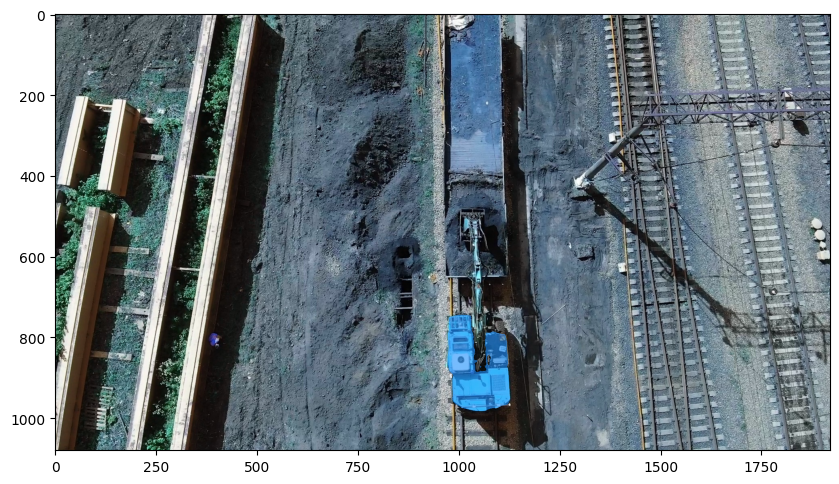

In [ ]:
predictor = SamPredictor(sam)
predictor.set_image(image)

input_box = np.array(boxes.xyxy.tolist())
print('input_box', input_box)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.savefig('output.png')
plt.show()

Получены приемлимые результаты на "тестовом решении", шаги по дальнейшему улучшению были описаны в процессе. Большое спасибо за потраченное время!